# 1. Install Dependencies and Setup

In [1]:
# !pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [2]:
# !pip list

In [3]:
import tensorflow as tf
import os

2024-10-14 19:10:07.995818: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-14 19:10:08.106217: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-10-14 19:10:08.106239: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-10-14 19:10:08.129126: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-14 19:10:08.696507: W tensorflow/stream_executor/platform/de

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus: 
#     tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
# tf.config.list_physical_devices('GPU')

# 2. Remove dodgy images

In [6]:
import cv2
import imghdr

In [7]:
data_dir = '/workspaces/ATAi_advance_notebooks/arthritis_data/all_images/'


In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [9]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory('/workspaces/ATAi_advance_notebooks/arthritis_data/all_images/')

Found 2060 files belonging to 2 classes.


2024-10-14 19:10:11.433679: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/envs/arthritis_env/lib/python3.10/site-packages/cv2/../../lib64:
2024-10-14 19:10:11.434430: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-10-14 19:10:11.434464: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (codespaces-ec4b37): /proc/driver/nvidia/version does not exist
2024-10-14 19:10:11.437603: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()

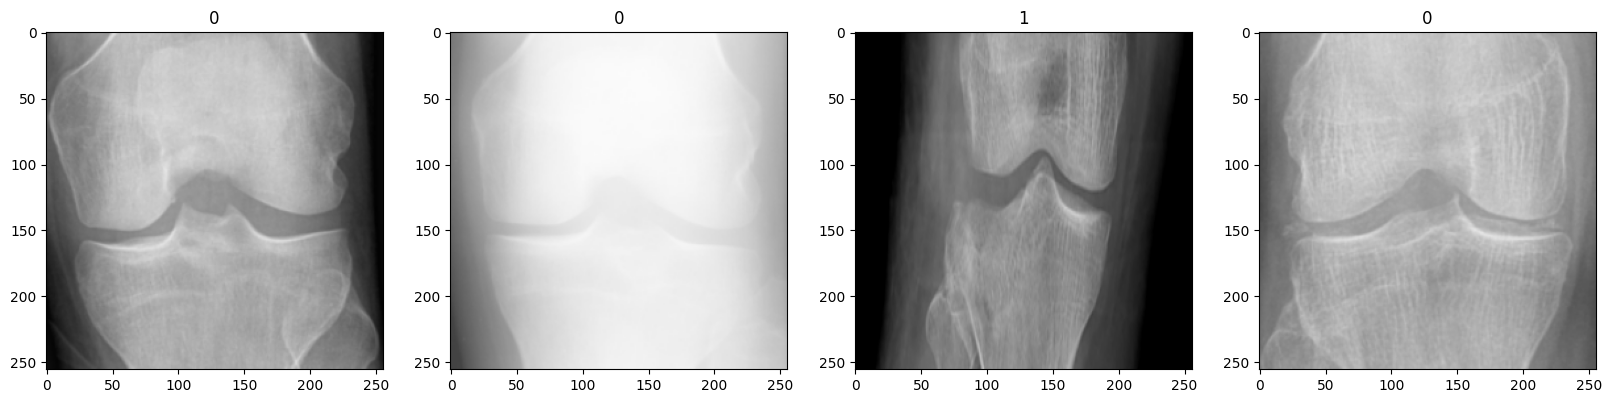

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [15]:
data = data.map(lambda x,y: (x/255, y))

In [16]:
data.as_numpy_iterator().next()

(array([[[[0.6784314 , 0.6784314 , 0.6784314 ],
          [0.6816176 , 0.6816176 , 0.6816176 ],
          [0.685049  , 0.685049  , 0.685049  ],
          ...,
          [0.30343136, 0.30343136, 0.30343136],
          [0.29656863, 0.29656863, 0.29656863],
          [0.2901961 , 0.2901961 , 0.2901961 ]],
 
         [[0.66568625, 0.66568625, 0.66568625],
          [0.66887254, 0.66887254, 0.66887254],
          [0.6701134 , 0.6701134 , 0.6701134 ],
          ...,
          [0.3044271 , 0.3044271 , 0.3044271 ],
          [0.2997549 , 0.2997549 , 0.2997549 ],
          [0.29338235, 0.29338235, 0.29338235]],
 
         [[0.660049  , 0.660049  , 0.660049  ],
          [0.66542584, 0.66542584, 0.66542584],
          [0.6629596 , 0.6629596 , 0.6629596 ],
          ...,
          [0.3028033 , 0.3028033 , 0.3028033 ],
          [0.3004902 , 0.3004902 , 0.3004902 ],
          [0.29411766, 0.29411766, 0.29411766]],
 
         ...,
 
         [[0.28235295, 0.28235295, 0.28235295],
          [0.28235

# 5. Split Data

In [17]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [18]:
train_size

45

In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [20]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0


In [53]:
model_set_up = "pretrained_binary" 

if model_set_up == "basic ": 
    model = Sequential()

    model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(16, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

elif (model_set_up == "pretrained_binary"):
    # Load the EfficientNetB0 model, excluding the top layers
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

    # Unfreeze some layers of the base model
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    # Add new top layers for binary classification
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Single output unit with sigmoid for binary classification
    ])

    # Compile the model for binary classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Fit the model with the TensorBoard callback
    logdir = 'logs'
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
    hist = model.fit(
        train, 
        steps_per_epoch=10, 
        epochs=5,
        validation_data=val,
        callbacks=[tensorboard_callback]  # Add the callback here
    )
else : 
    print("no model selected")

Epoch 1/5
10/10 [==============================] - 28s 2s/step - loss: 0.3693 - accuracy: 0.8531 - val_loss: 0.6924 - val_accuracy: 0.5312
Epoch 2/5
10/10 [==============================] - 21s 2s/step - loss: 0.2334 - accuracy: 0.9156 - val_loss: 0.7804 - val_accuracy: 0.5240
Epoch 3/5
10/10 [==============================] - 22s 2s/step - loss: 0.1659 - accuracy: 0.9531 - val_loss: 0.7034 - val_accuracy: 0.5264
Epoch 4/5
10/10 [==============================] - 22s 2s/step - loss: 0.1693 - accuracy: 0.9500 - val_loss: 0.8428 - val_accuracy: 0.4688
Epoch 5/5
10/10 [==============================] - 13s 1s/step - loss: 0.1037 - accuracy: 0.9688 - val_loss: 0.8941 - val_accuracy: 0.4880


In [54]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 8, 8, 1280)       4049571   
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 512)               655872    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
Total params: 4,705,956
Trainable params: 4,663,933
Non-trainable params: 42,023
_______________________________________

# 7. Train

In [27]:
logdir='logs'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/20
45/45 [==============================] - 81s 2s/step - loss: 0.1437 - accuracy: 0.9507 - val_loss: 3.1250 - val_accuracy: 0.5144
Epoch 2/20
45/45 [==============================] - 80s 2s/step - loss: 0.0711 - accuracy: 0.9736 - val_loss: 0.8272 - val_accuracy: 0.4808
Epoch 3/20
18/45 [===========>..................] - ETA: 42s - loss: 0.0276 - accuracy: 0.9931

# 8. Plot Performance

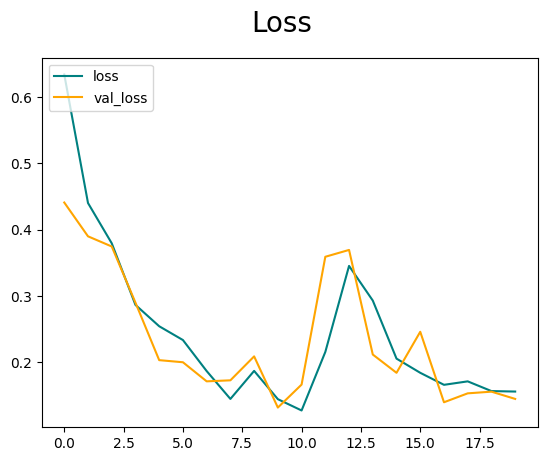

In [29]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

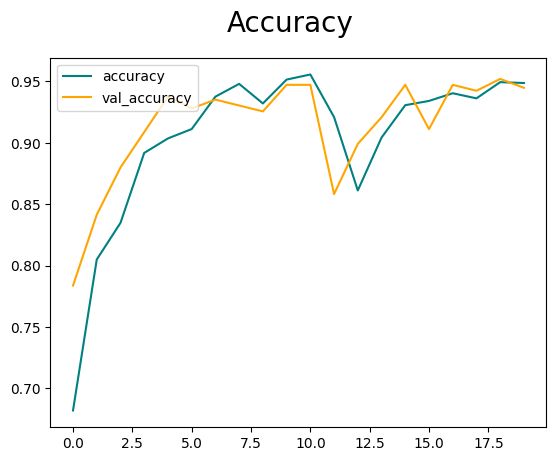

In [30]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [31]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [32]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [33]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 57ms/step


In [34]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.93406594, shape=(), dtype=float32) tf.Tensor(0.96875, shape=(), dtype=float32)


# 10. Test

In [35]:
import cv2

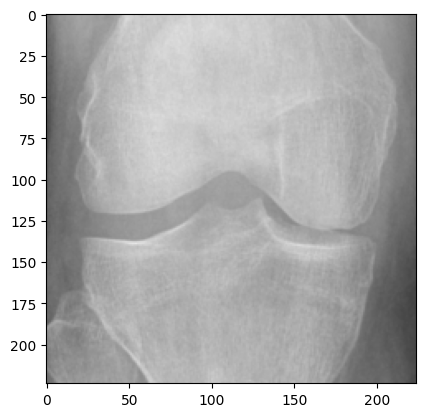

In [43]:
# img_path = "/workspaces/ATAi_advance_notebooks/arthritis_data/itsarthritis.jpg"
img_path = "/workspaces/ATAi_advance_notebooks/arthritis_data/notarthritis.jpg"


img = cv2.imread(img_path)
plt.imshow(img)
plt.show()

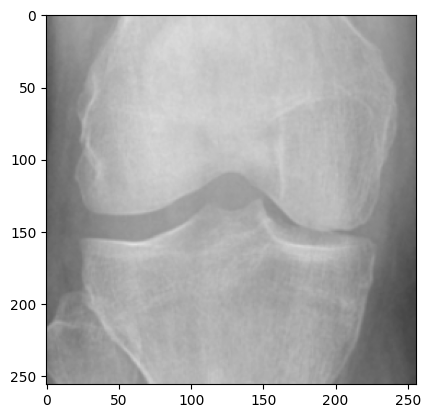

In [44]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()


In [45]:
yhat = model.predict(np.expand_dims(resize/255, 0))

yhat

if yhat > 0.5: 
    print(f'Predicted class is Arthritis')
else:
    print(f'Predicted class is NotArthritis')

1/1 [==============================] - 0s 23ms/step
Predicted class is NotArthritis


# 11. Save the Model

In [44]:
from tensorflow.keras.models import load_model

In [45]:
model.save(os.path.join('models','imageclassifier.h5'))

In [46]:
new_model = load_model('imageclassifier.h5')

In [47]:
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.01972741]], dtype=float32)